In [2]:
!pip install torch==2.1.2 torchvision==0.16.2 torchtext==0.16.2 \
    transformers==4.36.2 accelerate==0.25.0 huggingface_hub==0.20.3 \
    fsspec==2023.6.0 "numpy<2.0" tqdm datasets scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from tqdm import tqdm

Composing the model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Using device: cuda


Loading the dataset

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:18<00:00, 9109792.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Considered CIFAR dataset has 10 features so giving the feature count as 10

In [4]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Loss functions and optimizers

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training the Model with 20 epochs and added early stopping to avoid overfitting

In [ ]:
num_epochs = 20
patience = 3
best_val_acc = 0.0
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Train Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "resnet_cifar10.pt")
        print("Model saved as resnet_cifar10.pt (improved validation accuracy)")
    else:
        patience_counter += 1
        print(f"No improvement. EarlyStopping patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/20: 100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Train Loss: 1.3472, Train Acc: 50.79%
Validation Accuracy: 65.87%
Model saved as resnet_cifar10.pt (improved validation accuracy)


Epoch 2/20: 100%|██████████| 782/782 [03:47<00:00,  3.43it/s]


Train Loss: 0.7998, Train Acc: 71.85%
Validation Accuracy: 70.54%
Model saved as resnet_cifar10.pt (improved validation accuracy)


Epoch 3/20: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Train Loss: 0.6083, Train Acc: 78.66%
Validation Accuracy: 77.59%
Model saved as resnet_cifar10.pt (improved validation accuracy)


Epoch 4/20: 100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Train Loss: 0.4855, Train Acc: 83.02%
Validation Accuracy: 80.88%
Model saved as resnet_cifar10.pt (improved validation accuracy)


Epoch 5/20: 100%|██████████| 782/782 [03:46<00:00,  3.46it/s]


Train Loss: 0.3878, Train Acc: 86.39%
Validation Accuracy: 82.61%
Model saved as resnet_cifar10.pt (improved validation accuracy)


Epoch 6/20: 100%|██████████| 782/782 [03:53<00:00,  3.35it/s]


Train Loss: 0.2955, Train Acc: 89.75%
Validation Accuracy: 81.37%
No improvement. EarlyStopping patience: 1/3


Epoch 7/20: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]


Train Loss: 0.2253, Train Acc: 91.98%
Validation Accuracy: 81.84%
No improvement. EarlyStopping patience: 2/3


Epoch 8/20: 100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Train Loss: 0.1651, Train Acc: 94.32%
Validation Accuracy: 81.38%
No improvement. EarlyStopping patience: 3/3
Early stopping triggered.


Inferences Starts from here


In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
from google.colab import files
import io
import matplotlib.pyplot as plt

In [8]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Loading the custom trained model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load("resnet_cifar10.pt", map_location=device))
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Definining preprocessing

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Predictions

Saving images.jpg to images.jpg


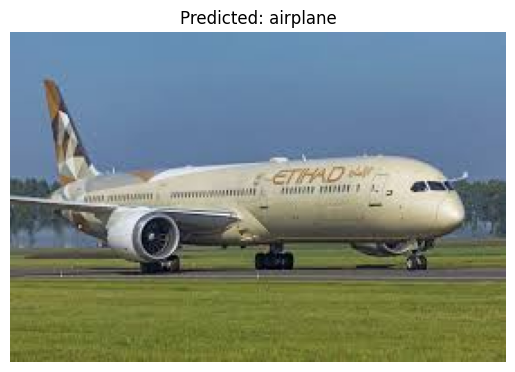

Uploaded image: images.jpg
Predicted class: airplane


In [11]:
uploaded = files.upload()

for filename in uploaded.keys():

    image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {cifar10_classes[predicted.item()]}")
    plt.show()

    print(f"Uploaded image: {filename}")
    print(f"Predicted class: {cifar10_classes[predicted.item()]}")